# GIS Data Exploration

### Description



### Files
1. 
2.
3.

### Evaluation

Evaluation Metric Template

Submission File
For each id in the test set, you must predict a probability a failure. The file should contain a header and have the following format:

- id,failure
- 26570,0.2
- 26571,0.1
- 26572,0.9
- etc.

### Important Points
- Different prototypes tested for product failures
- Given product attributes and measurement values, so only 2 types of attributes
- The simulated test uses loading
- You must predict individual product failures of new new codes with their lab test results

## Package Importing

In [1]:
# general python libraries
import time
import sys
import datetime
import math
import numpy as np

# dataframe and data manipulation library
import pandas as pd

# visualisation and EDA libraries
import matplotlib.pyplot as  plt
import seaborn as sns
import popmon
from popmon import resources
from popmon.config import Report, Settings

# GIS
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [2]:
%matplotlib inline

## Data Importing

In [3]:
# specify name of file
#dataset_name = 'airview_dublincity_measurements_ugm3'
dataset_name = 'airview_dublincity_roaddata_ugm3'


folder_path = f'../data/raw/{dataset_name}'
shapefile_path = f'{folder_path}/{dataset_name}.shp'



In [5]:
# read in shapefile
gdf = gpd.read_file(shapefile_path)
gdf.head(5)

,road_id,osm_id,osm_code,osm_fclass,osm_name,osm_ref,osm_oneway,osm_maxspe,osm_layer,osm_bridge,...,COpoints,COdrives,CO_mgm3,O3points,O3drives,O3_ugm3,PM25points,PM25drives,PM25_ugm3,geometry
0,3633278,497788125,5141,service,None,None,B,30,0,false,...,0,NaN,NaN,0,NaN,NaN,2,1.0,3.030,"LINESTRING (-6.15647 53.39440, -6.15665 53.39408)"
1,3639035,500417276,5141,service,None,None,B,0,0,false,...,0,NaN,NaN,0,NaN,NaN,1,1.0,5.042,"LINESTRING (-6.32663 53.34215, -6.32662 53.342..."
2,2099409,236680313,5141,service,None,None,B,0,0,false,...,0,NaN,NaN,0,NaN,NaN,1,1.0,32.500,"LINESTRING (-6.18915 53.37956, -6.18953 53.37994)"
3,3636088,498987932,5141,service,None,None,B,0,0,false,...,0,NaN,NaN,0,NaN,NaN,1,1.0,6.882,"LINESTRING (-6.27962 53.32629, -6.27965 53.326..."
4,3962473,684445633,5141,service,None,None,B,0,0,false,...,0,NaN,NaN,1,1.0,54.447,1,1.0,7.111,"LINESTRING (-6.26444 53.31320, -6.26444 53.313..."


<AxesSubplot: >

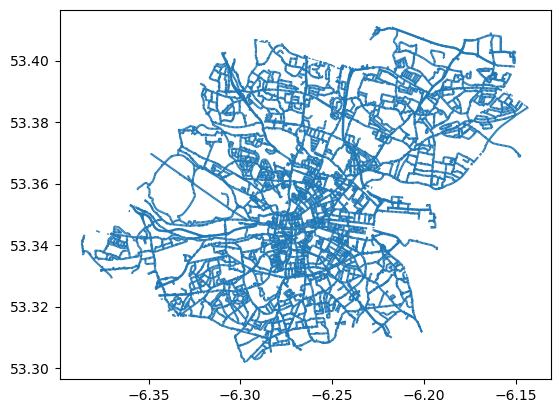

In [8]:
gdf.plot()

## Dataset Summaries and Heads

In [9]:
print("Number of rows in train data:    \t",gdf.shape[0])
print("Number of columns in train data: \t",gdf.shape[1])

Number of rows in train data:    	 24694
Number of columns in train data: 	 30


In [10]:
# check datatypes of columns
print(gdf.dtypes.value_counts())

float64     12
object      11
int64        6
geometry     1
dtype: int64


non-numeric column categories based on data from  24694 rows


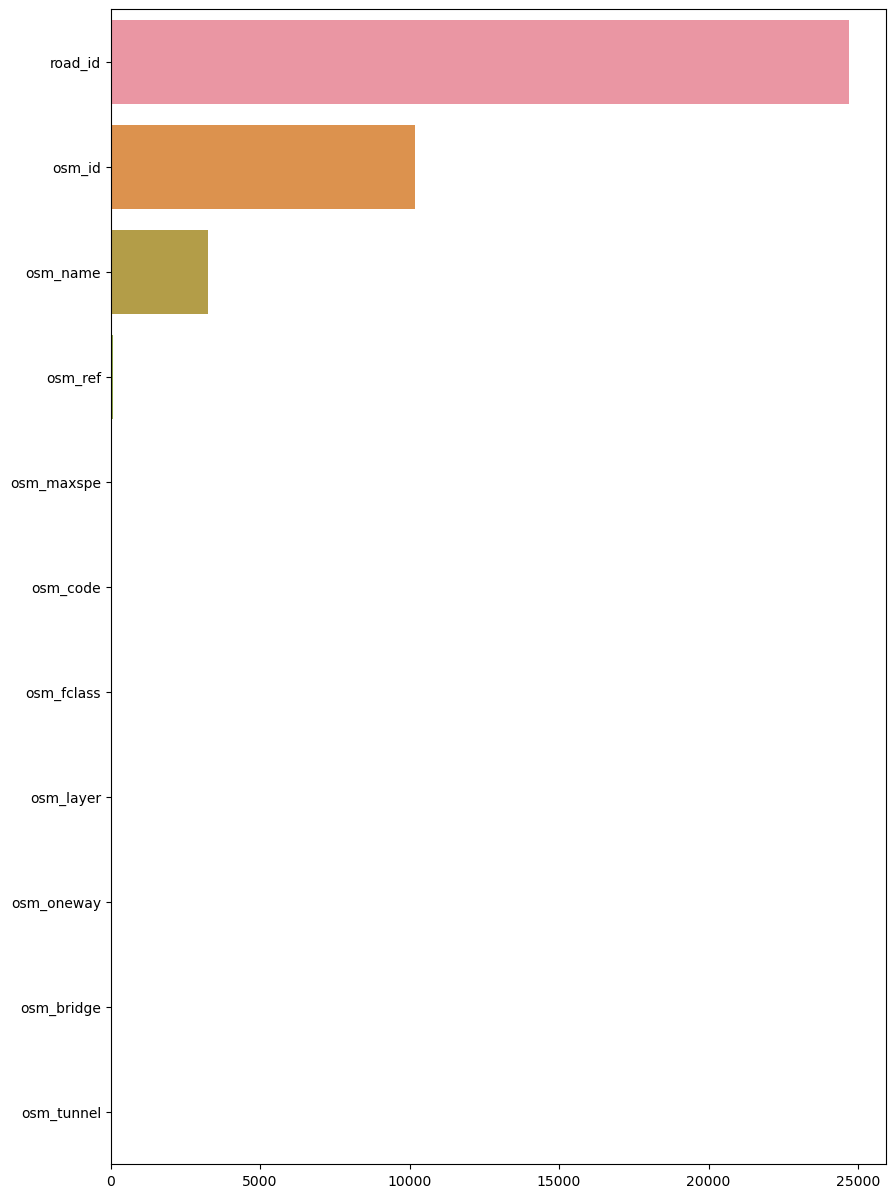

In [11]:
# save names of categorical columns
numeric_cols = gdf.dtypes[gdf.dtypes != "object"].index
cat_cols = gdf.dtypes[gdf.dtypes == "object"].index

# view cardinalitites of categorical columns
print('non-numeric column categories based on data from ', gdf.shape[0],'rows')

cat_name = []
nunique_vals = []
for i in cat_cols:
    cat_name.append(i)
    nunique_vals.append(gdf.loc[:,i].nunique())

cat_counts = pd.Series(data=nunique_vals,index=cat_name).sort_values(ascending = False)

fig = plt.figure(figsize=(10,15))
ax = sns.barplot(y = cat_counts.index, x = cat_counts, orient='h')

In [12]:
# checking missing data
total = gdf.isnull().sum().sort_values(ascending = False)
percent = (gdf.isnull().sum()/gdf.isnull().count()*100).sort_values(ascending = False)
missing_gdf  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_gdf

,Total,Percent
osm_ref,18279,74.022030
osm_name,4485,18.162307
O3drives,1248,5.053859
O3_ugm3,1248,5.053859
CO2drives,205,0.830161
CO2_mgm3,205,0.830161
NO2_ugm3,199,0.805864
NO2drives,199,0.805864
NOdrives,84,0.340164
NO_ugm3,84,0.340164


## Distributional drift and comparisons

In [13]:
gdf.columns

Index(['road_id', 'osm_id', 'osm_code', 'osm_fclass', 'osm_name', 'osm_ref',
       'osm_oneway', 'osm_maxspe', 'osm_layer', 'osm_bridge', 'osm_tunnel',
       'NO2points', 'NO2drives', 'NO2_ugm3', 'NOpoints', 'NOdrives', 'NO_ugm3',
       'CO2points', 'CO2drives', 'CO2_mgm3', 'COpoints', 'COdrives', 'CO_mgm3',
       'O3points', 'O3drives', 'O3_ugm3', 'PM25points', 'PM25drives',
       'PM25_ugm3', 'geometry'],
      dtype='object')

each of the products could have very different behaviours and be from different populations. And so it may make sense to look at each on of these individually

## Static Profiling

In [14]:
# sample data if required if reports too big
train_sample = gdf.sample(10000)

# drop id column
train_sample.drop('id',axis = 1, inplace=True)

# drop index or else that will also be profiled
train_sample.reset_index(drop=True, inplace=True)

KeyError: "['id'] not found in axis"

In [ ]:
# create minimal report in reports
minimal_report = gdf.profile_report(title="Minimal Report",minimal=True)
minimal_report.to_file("../reports/pp_eda_minimal.html")
#minimal_report.to_notebook_iframe()

In [ ]:
# set of parameters to create customer report
gdf.profile_report(
    title="Custom Report",
    # create missing/null value diagrams
    # disable if no missing values
    missing_diagrams={
        "heatmap": True,
        "dendrogram": True,
        "bar": True,
        "matrix":True
    # create all correlation plots
    # the correlations and interactions come together
    # the correlations section dictates which corrs will be run
    # the interactions dicatates which variables
    },correlations={
        # strength and directional
        # continuous vars, linear, sensitive to outliers, normal dist
        "pearson": {"calculate": True},
        # strength and directional
        # categorical or quant, linear, no outliers
        "spearman": {"calculate": False},
        # 0-1
        # dependence of 2 vars.
        "kendall": {"calculate": True},
        # no direction, categorical, ordinal, interval
        # non-linear dependency
        # computationally expensive
        "phi_k": {"calculate": True}, # this one is one of the most intensive ones
        # compares 2 categorical vars
        # based on chi-squared test stat
        # sensitive to outlies
        "cramers": {"calculate": True}
    },interactions = {
        # this generates 2d scatter, this will cause crash if too many variables
        "continuous": False
        # comment continouous out and put in 
        # target var to see scatter between
        # only these values and all other
        # values
        #"targets": ['target']
    },html = {
        "style": {"theme":"flatly"}
    }
    
    
).to_file("../reports/pp_eda_custom.html")

## Data Cleaning

Creation of data cleaning function to;
- Impute NULL Values
- Parse Multi-part string columns
- Drop columns
- Encode categorical variables
- Normalise or scale columns

In [ ]:
def Preprocessing(df):
    
    df = pd.get_dummies(df) # convert all categorical variables to dummy variables
    
    df = df.dropna(
        # axis = 1 # default both axes, comment out for only 1 axis
    ) # remvoe all na rows or columns
    
    return df

gdf_cleaned = Preprocessing(gdf)

print("missing values present:",gdf_cleaned.isna().sum().sum())
print("categorical columns present:",gdf_cleaned.dtypes[gdf_cleaned.dtypes == "object"].count())



## Model fitting

### Train Test Split

Splitting data into groupings for model fitting

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    gdf_cleaned.drop(['id','failure'], axis = 1), # X data excluding target variable and any irrelevant id columns
    gdf_cleaned.loc[:,'failure'],
    test_size = 0.2, # 0.2 is a good accepted starting point, with larger data this number can be decreased
    random_state = 42, # random seed, default 42
    shuffle = True # default true, check whether there is population drift over time in default order
)

print("Shape of X_train data:    \t",X_train.shape)
print("Shape of X_test data:    \t",X_test.shape)
print("Shape of y_train data:    \t",y_train.shape)
print("Shape of y_test data:    \t",y_test.shape)

NameError: name 'train_test_split' is not defined

### Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression
# help(LinearRegression)

In [18]:
# initialise new linear regression object model
model = LinearRegression()

In [19]:
# Fir regression model
model.fit(X_train, y_train)

LinearRegression()

In [20]:
# predict values on test set
test_preds = model.predict(X_test)

In [ ]:
test_residuals = y_test - test_preds

# ideally this is normal
sns.scatterplot(x=y_test,y=test_residuals)
plt.axhline(y=0,color='r',ls='--')

In [ ]:
# these coeffients will be in different units
model.coef_

In [ ]:
from joblib import dump, load
dump(model,'../models/linear_regression_model.joblib')